Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.0.2

torch: 2.6.0+cu126



- Runs on CPU or GPU (if available)

# VGG16 Convolutional Neural Network for Kaggle's Cats and Dogs Images

Implementation of the VGG-16 [1] architecture for training a dogs vs cats classifier.  
实现 VGG-16 [1] 架构，用于训练狗与猫分类器。

References  
参考文献

- [1] Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.  
- [1] Simonyan, K., & Zisserman, A. (2014). 用于大规模图像识别的非常深的卷积网络。arXiv 预印本 arXiv:1409.1556。

## Imports

In [2]:
import time
import os

import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.cuda.set_per_process_memory_fraction(0.7, device=0)

In [3]:
%matplotlib inline

## Settings

In [4]:
##########################
### 参数设置
##########################

# 设备
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 超参数设置
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 128

# 模型结构相关配置
NUM_CLASSES = 2

## Cats vs Dogs Dataset

Download the Kaggle Cats and Dogs Dataset from https://www.kaggle.com/c/dogs-vs-cats/data by clicking on the "Download All" link:  
从 https://www.kaggle.com/c/dogs-vs-cats/data 下载 Kaggle 猫狗数据集，点击 "Download All" 链接：

![](images/cats-and-dogs-download-all.png)

Then, unzip the dataset.  
然后，解压数据集。

The dataset folder consists of two subfolders, `train`, and `test1`, which contain the training and test images in jpg format, respectively. Note that the test set examples are unlabeled.  
数据集文件夹包含两个子文件夹，`train` 和 `test1`，分别包含训练和测试图像（jpg 格式）。请注意，测试集示例没有标签。

```python

import os

num_train_cats = len([i for i in os.listdir(os.path.join('dogs-vs-cats', 'train')) 
                      if i.endswith('.jpg') and i.startswith('cat')])

num_train_dogs = len([i for i in os.listdir(os.path.join('dogs-vs-cats', 'train')) 
                      if i.endswith('.jpg') and i.startswith('dog')])
                            
print(f'Training set cats: {num_train_cats}')
print(f'Training set dogs: {num_train_dogs}')

```

The naming scheme within each of these subfolders is `<class>.<imagenumber>.jpg`.  
每个子文件夹中的命名规则是 `<class>.<imagenumber>.jpg`。

(331, 464, 3)


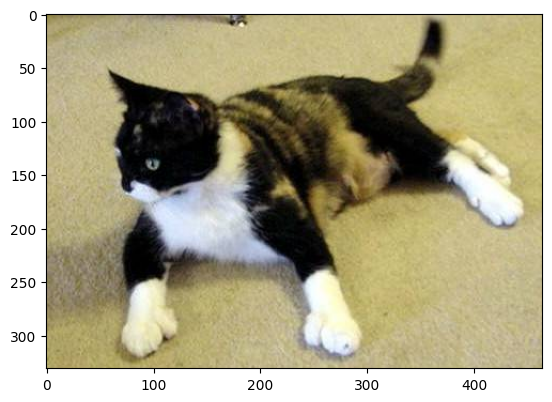

In [5]:
img = Image.open(os.path.join('dogs-vs-cats','train', 'cat.59.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

### Creating Validation and Test Subsets

- Move 2500 images from the training folder into a test set folder  
  将 2500 张图像从训练文件夹移动到测试集文件夹

- Move 2500 images from the training folder into a validation set folder  
  将 2500 张图像从训练文件夹移动到验证集文件夹

In [6]:
if not os.path.exists(os.path.join('dogs-vs-cats', 'test')):
    os.mkdir(os.path.join('dogs-vs-cats', 'test'))

if not os.path.exists(os.path.join('dogs-vs-cats', 'valid')):
    os.mkdir(os.path.join('dogs-vs-cats', 'valid'))

In [7]:
for fname in os.listdir(os.path.join('dogs-vs-cats', 'train')):
    if not fname.endswith('.jpg'):
        continue
    _, img_num, _ = fname.split('.')
    filepath = os.path.join('dogs-vs-cats', 'train', fname)
    img_num = int(img_num)
    if img_num > 11249:
        os.rename(filepath, filepath.replace('train', 'test'))
    elif img_num > 9999:
        os.rename(filepath, filepath.replace('train', 'valid'))

### Standardizing Images

Getting mean and standard deviation for normalizing images via z-score normalization.  
通过 z-score 标准化获取图像的均值和标准差。

For details, see the related notebook [./cnn-standardized.ipynb](cnn-standardized.ipynb).  
有关详细信息，请参阅相关的笔记本 [./cnn-standardized.ipynb](cnn-standardized.ipynb)。

In [8]:
class CatsDogsDataset(Dataset):
    """自定义数据集，用于加载猫狗图像"""

    def __init__(self, img_dir, transform=None):
        # 初始化，img_dir是图像所在的目录，transform是可选的图像转换操作
        self.img_dir = img_dir
        
        # 获取目录下所有以.jpg结尾的图像文件名
        self.img_names = [i for i in 
                          os.listdir(img_dir) 
                          if i.endswith('.jpg')]
        
        # 根据文件名判断标签，'cat'对应标签0，其他（假设为'狗'）对应标签1
        self.y = []
        for i in self.img_names:
            if i.split('.')[0] == 'cat':
                self.y.append(0)
            else:
                self.y.append(1)
        
        # 存储图像转换操作
        self.transform = transform

    def __getitem__(self, index):
        # 根据索引获取图像并进行处理
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        # 如果有指定的转换操作，则进行转换
        if self.transform is not None:
            img = self.transform(img)
        
        # 获取该图像对应的标签
        label = self.y[index]
        return img, label

    def __len__(self):
        # 返回数据集的大小
        return len(self.y)

    

# 定义图像预处理流程，调整大小并转换为Tensor
custom_transform1 = transforms.Compose([transforms.Resize([64, 64]),  # 调整图像大小为64x64
                                        transforms.ToTensor()])     # 转换为Tensor格式

# 创建训练数据集，指定图像目录和预处理操作
train_dataset = CatsDogsDataset(img_dir=os.path.join('dogs-vs-cats', 'train'), 
                                transform=custom_transform1)

# 使用DataLoader加载数据集，批次大小为5000，数据不打乱
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=5000, 
                          shuffle=False)

train_mean = []  # 存储每个批次的均值
train_std = []   # 存储每个批次的标准差

# 遍历训练数据集，计算均值和标准差
for i, image in enumerate(train_loader, 0):
    numpy_image = image[0].numpy()  # 将图像转换为NumPy数组
    
    # 计算每个批次的均值和标准差
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))  # 计算图像通道维度上的均值
    batch_std = np.std(numpy_image, axis=(0, 2, 3))    # 计算图像通道维度上的标准差
    
    train_mean.append(batch_mean)  # 存储批次均值
    train_std.append(batch_std)    # 存储批次标准差

# 计算所有批次的均值和标准差
train_mean = torch.tensor(np.mean(train_mean, axis=0))  # 计算均值的总平均
train_std = torch.tensor(np.mean(train_std, axis=0))    # 计算标准差的总平均

# 输出最终的均值和标准差
print('Mean:', train_mean)
print('Std Dev:', train_std)


Mean: tensor([0.4875, 0.4544, 0.4164])
Std Dev: tensor([0.2519, 0.2451, 0.2480])


### Dataloaders

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}


train_dataset = CatsDogsDataset(img_dir=os.path.join('dogs-vs-cats', 'train'), 
                                transform=data_transforms['train'])

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

valid_dataset = CatsDogsDataset(img_dir=os.path.join('dogs-vs-cats', 'valid'), 
                                transform=data_transforms['valid'])

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

test_dataset = CatsDogsDataset(img_dir=os.path.join('dogs-vs-cats', 'test'), 
                               transform=data_transforms['valid'])

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

## Model

In [10]:
##########################
### 模型定义（VGG16）
##########################


class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        
        # 计算 same padding（保持输出尺寸不变）：
        # (w - k + 2*p)/s + 1 = o
        # 推导出：p = (s(o-1) - w + k)/2
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
        
        self.classifier = nn.Sequential(
                nn.Linear(512*2*2, 4096),
                nn.ReLU(),   
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Linear(4096, num_classes)
        )
            
        
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                #n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                #m.weight.data.normal_(0, np.sqrt(2. / n))
                m.weight.detach().normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0, 0.05)
                m.bias.detach().detach().zero_()
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        logits = self.classifier(x.view(-1, 512*2*2))
        probas = F.softmax(logits, dim=1)

        return logits, probas

In [11]:
torch.manual_seed(RANDOM_SEED)
model = VGG16(num_classes=NUM_CLASSES)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [12]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### 准备小批量数据
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### 正向传播和反向传播
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### 更新模型参数
        optimizer.step()
        
        ### 记录日志
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # 在计算准确率时不需要构建计算图（反向传播）
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/100 | Batch 000/156 | Cost: 1016.1614
Epoch: 001/100 | Batch 120/156 | Cost: 0.7466
Epoch: 001/100 Train Acc.: 63.34% | Validation Acc.: 60.64%
Time elapsed: 2.08 min
Epoch: 002/100 | Batch 000/156 | Cost: 0.5416
Epoch: 002/100 | Batch 120/156 | Cost: 0.7063
Epoch: 002/100 Train Acc.: 63.76% | Validation Acc.: 64.96%
Time elapsed: 4.16 min
Epoch: 003/100 | Batch 000/156 | Cost: 0.6993
Epoch: 003/100 | Batch 120/156 | Cost: 0.5933
Epoch: 003/100 Train Acc.: 66.79% | Validation Acc.: 64.92%
Time elapsed: 6.23 min
Epoch: 004/100 | Batch 000/156 | Cost: 0.6403
Epoch: 004/100 | Batch 120/156 | Cost: 0.6432
Epoch: 004/100 Train Acc.: 65.82% | Validation Acc.: 66.60%
Time elapsed: 8.33 min
Epoch: 005/100 | Batch 000/156 | Cost: 0.6290
Epoch: 005/100 | Batch 120/156 | Cost: 0.6281
Epoch: 005/100 Train Acc.: 66.05% | Validation Acc.: 63.80%
Time elapsed: 10.43 min
Epoch: 006/100 | Batch 000/156 | Cost: 0.6556
Epoch: 006/100 | Batch 120/156 | Cost: 0.5715
Epoch: 006/100 Train Acc.: 60

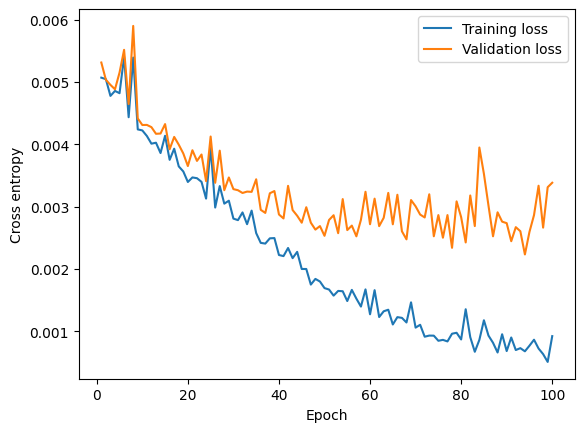

In [13]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

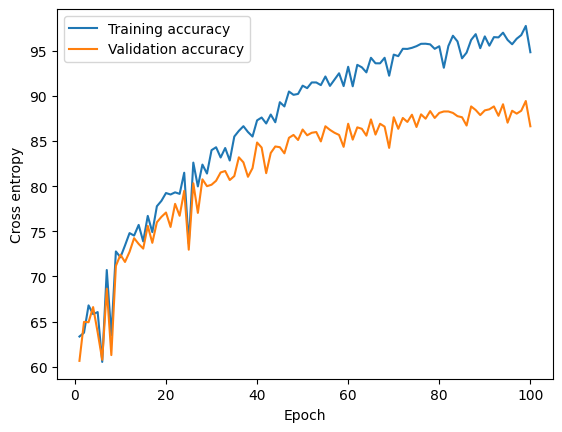

In [14]:
train_acc_lst_cpu = [x.cpu().numpy() for x in train_acc_lst]   # 将张量移到 CPU 并转换为 numpy 数组
valid_acc_lst_cpu = [x.cpu().numpy() for x in valid_acc_lst]
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst_cpu, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst_cpu, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

## Evaluation

In [15]:
model.eval()
with torch.set_grad_enabled(False): # 在推理过程中禁用梯度计算，节省内存
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 62.81%


In [16]:
class UnNormalize(object):
    def __init__(self, mean, std):
        # 初始化时传入均值和标准差
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        反向归一化处理
        Args:
            tensor (Tensor): 输入的Tensor图像，尺寸为(C, H, W)。
        Returns:
            Tensor: 反向归一化后的图像。
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            # 反归一化公式：t = t * s + m
            t.mul_(s).add_(m)
            # normalize的代码是：t.sub_(m).div_(s)
        return tensor
    
# 创建UnNormalize对象，传入训练数据集的均值和标准差
unorm = UnNormalize(mean=train_mean, std=train_std)


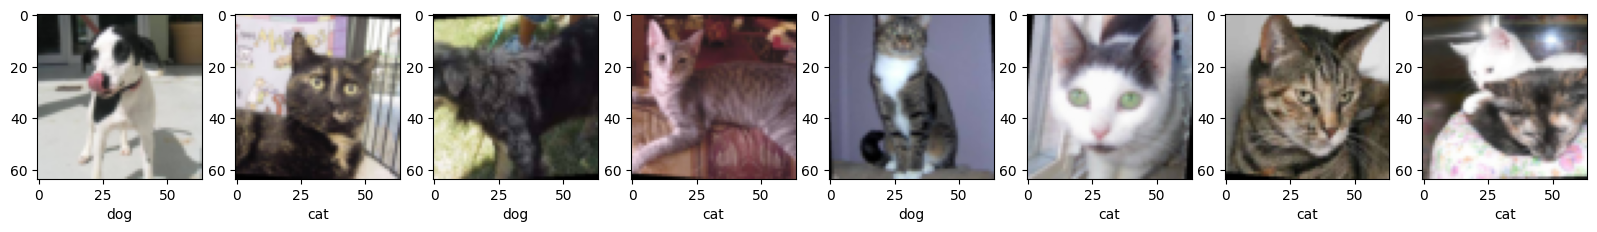

In [17]:
test_loader = DataLoader(dataset=train_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

for features, targets in test_loader:
    break
    

_, predictions = model.forward(features[:8].to(DEVICE))
predictions = torch.argmax(predictions, dim=1)

d = {0: 'cat',
     1: 'dog'}
    
fig, ax = plt.subplots(1, 8, figsize=(20, 10))
for i in range(8):
    img = unorm(features[i])
    ax[i].imshow(np.transpose(img, (1, 2, 0)))
    ax[i].set_xlabel(d[predictions[i].item()])

plt.show()